In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Grouping and Pivoting

This section introduces *grouping* and *pivoting*, two common operations for
aggregating data.

We'll work with the baby names data, as introduced in the previous section:

In [2]:
baby = pd.read_csv('babynames.csv')
baby

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880
2020721,Wilma,F,5,1880


## Basic Group-Aggregate

Say you want to find out the total number of babies born as recorded in this
data. This is simply the sum of the `Count` column:

In [3]:
baby['Count'].sum()

352554503

But let's say you want to know: are U.S. births trending upwards over time? To
answer this question, you need to sum the `Count` column within each year. In
other words, you need to split the data into groups based on `Year`, then
sum up the `Count` values within each group.

```{figure} figures/groupby-births.svg
---
name: groupby-births
alt: groupby-births
---
A depiction of grouping then aggregating for example data.
```

We call this operation **grouping** followed by **aggregating**. In `pandas`, you
would write: 

In [4]:
baby.groupby('Year')['Count'].sum()

Year
1880     194419
1881     185772
1882     213385
         ...   
2018    3487193
2019    3437438
2020    3287724
Name: Count, Length: 141, dtype: int64

Notice that the code is nearly the same as the non-grouped version, except that
it starts with a call to `.groupby('Year')`.

The result is a `pd.Series` with the total babies born for each year in the
data. Notice that the index of this series contains the unique `Year` values.
Now you can plot the counts over time:

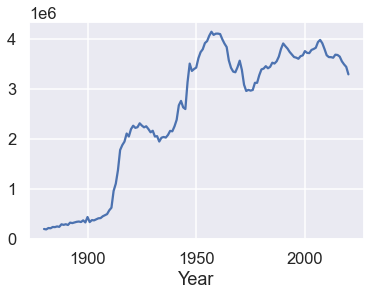

In [5]:
counts_by_year = baby.groupby('Year')['Count'].sum()
counts_by_year.plot();

What do you see in this plot? First, you might notice that there seem to be
suspiciously few babies born before 1920. One likely explanation is that the
Social Security Administration was created in 1935, so its data for prior
births could be less complete.

You might also notice the dip when World War II began in 1939, and the
post-war Baby Boomer era from 1946-1964.

Here's the basic recipe for grouping in `pandas`:

```python
(baby                # the dataframe
 .groupby('Year')    # columns to group
 ['Count']           # columns to aggregate
 .sum()              # how to aggregate
)
```

## Grouping on Multiple Columns

You can pass multiple columns into `.groupby` as a list to group by multiple
columns at once. This is useful when you need to further subdivide your groups.
For example, we can group by both year and sex to see how many male and female
babies were born over time.

In [6]:
counts_by_year_and_sex = (baby
 .groupby(['Year', 'Sex']) # Arg to groupby is a list of column names
 ['Count']
 .sum()
)
counts_by_year_and_sex 

Year  Sex
1880  F        83929
      M       110490
1881  F        85034
              ...   
2019  M      1785527
2020  F      1581301
      M      1706423
Name: Count, Length: 282, dtype: int64

Notice how the code closely follows the grouping recipe.

The `counts_by_year_and_sex` series has what we call a multi-level index with
two levels, one for each column that was grouped. It's a bit easier to see if
we convert the series to a dataframe:

In [7]:
# The result only has one column
counts_by_year_and_sex.to_frame()

Count
Year Sex         
1880 F      83929
     M     110490
1881 F      85034
...           ...
2019 M    1785527
2020 F    1581301
     M    1706423

[282 rows x 1 columns]

There are two levels to the index because we grouped by two columns. It can be
a bit tricky to work with multilevel indices, so you can reset the index to go
back to a dataframe with a single index.

In [8]:
counts_by_year_and_sex.reset_index()

,Year,Sex,Count
0,1880,F,83929
1,1880,M,110490
2,1881,F,85034
...,...,...,...
279,2019,M,1785527
280,2020,F,1581301
281,2020,M,1706423


## Custom Aggregation Functions

Have people become more creative with baby names over time? One way to measure
this is to see whether the number of *unique* baby names per year has increased
over time.

After grouping, `pandas` gives us flexible ways to aggregate the data. So far,
you've seen how to use `.sum()` after grouping:

In [9]:
(baby
 .groupby('Year')
 ['Count']
 .sum() # aggregate by summing
)

Year
1880     194419
1881     185772
1882     213385
         ...   
2018    3487193
2019    3437438
2020    3287724
Name: Count, Length: 141, dtype: int64

`pandas` also supplies other aggregation functions, like `.mean()`, `.size()`,
and `.first()`. Here's the same grouping using `.max()`:

In [10]:
(baby
 .groupby('Year')
 ['Count']
 .max() # aggregate by taking the max within each group
)

Year
1880     9655
1881     8769
1882     9557
        ...  
2018    19924
2019    20555
2020    19659
Name: Count, Length: 141, dtype: int64

But finding the number of unique values isn't provided as a pre-built
aggregation function. In these cases, you need to define and use a custom
aggregation function. `pandas` lets you do this through `.agg(fn)`, where `fn`
is a function that you define.

So, start by defining a `count_unique` function that counts the number of
unique values in a series. Then, pass that function into `.agg()`.

In [11]:
# The input to this function is a Series containing a column within a group
def count_unique(s):
    return len(s.unique())

unique_names_by_year = (baby
 .groupby('Year')
 ['Name']
 .agg(count_unique) # aggregate using the custom count_unique function
)
unique_names_by_year

Year
1880     1889
1881     1829
1882     2012
        ...  
2018    29619
2019    29417
2020    28613
Name: Name, Length: 141, dtype: int64

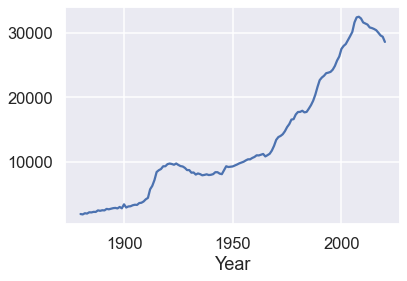

In [12]:
unique_names_by_year.plot();

We see that the number of unique names has generally increased over time, even
though the number of babies born has mostly stabilized since the 1960s.

## Pivoting

Pivoting is essentially a convenient way to arrange the results of a group and
aggregation when grouping with two columns. Earlier in this section we grouped
the baby names data by year and sex:

In [13]:
counts_by_year_and_sex = (baby
 .groupby(['Year', 'Sex']) 
 ['Count']
 .sum()
)
counts_by_year_and_sex.to_frame()

Count
Year Sex         
1880 F      83929
     M     110490
1881 F      85034
...           ...
2019 M    1785527
2020 F    1581301
     M    1706423

[282 rows x 1 columns]

This produces a `pd.Series` with the counts. We can also imagine the same data
with the `Sex` index level "pivoted" to the columns of a dataframe. It's easier
to see with an example:

In [14]:
pd.pivot_table(baby,
               index='Year',     # Index for rows
               columns='Sex',    # Columns
               values='Count',   # Values in table
               aggfunc=sum)      # Aggregation function

Sex,F,M
Year,,
1880,83929,110490
1881,85034,100738
1882,99699,113686
...,...,...
2018,1676884,1810309
2019,1651911,1785527
2020,1581301,1706423


Notice that the data values are identical, just arranged differently. Pivot
tables are useful for quickly summarizing data using two attributes, and you'll
see them often in articles and papers.